От сотрудников Института Цитологии и Генетики СО РАН были получены данные о продолжительности жизни больных с боковым амиотрофическим склерозом(болезнь Стивена Хокинга), 
где Omega stability - некоторое значение, соответствующее мутации в белке, а Survival time - продолжительность жизни пациента при этой мутации.

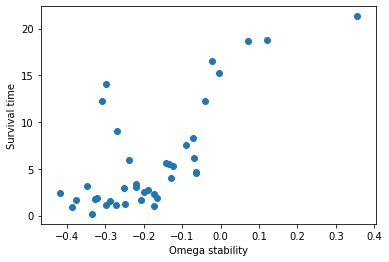

In [8]:
# Загрузим данные с помощью модуля Pandas в объект DataFrame
import numpy as np
import pandas as pd
omega_stability = pd.read_csv('omega_stability.csv')

# Проведем первичную обработку данных
omega_stability = omega_stability.T
omega_stability = omega_stability.drop(index = "Name")
omega_stability.columns = ["Omega stability", "Survival time"]

# Преобразуем значения ячеек в числовые
omega_stability["Omega stability"] = omega_stability["Omega stability"].astype(float)
omega_stability["Survival time"] = omega_stability["Survival time"].astype(float)

x = omega_stability["Omega stability"].values
y = omega_stability["Survival time"].values

# Проведем сортировку данных 
x, y = zip(*sorted(zip(x, y)))
x = np.asarray(x)
y = np.asarray(y)

# Проведем визуализацию
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlabel('Omega stability')
ax.set_ylabel('Survival time')
ax.scatter(x, y)

Поставлена задача определить оптимальную регрессионную модель для прогнозирования времени дожития пациентов с БАС.

Будут рассмотрены следующие функции:
1. Линейная $$f(x) = a_{0} + a_{1}x$$
2. Кубическая $$f(x) = a_{0} + a_{1}x + a_{2}x^{2} + a_{3}x^{3}$$
3. Логистическая $$f(x) = \frac{a_{0}}{1 + e^{-a_{1}(x-a_{2})}}$$

Оценивать параметры линейно-параметризованных функций(линейная и кубическая) будем с помощью системы нормальных уравнений регрессии.
Для оценивания параметров логистической функции, а также линейной и кубической функций с функцией потерь Хьюбера, будем применять алгоритм Левенберга-Макгварда.
